In [2]:
import pandas as pd
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [12, 6]
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

In [4]:
filenames = (os.listdir("data/"))

In [5]:
data = pd.DataFrame(columns={"question","answer","category"})

In [6]:
for file in filenames:
    
    data_curr = pd.DataFrame(columns={"question","answer","category"})
    
    file = open("data/"+file)
    file = yaml.load(file)
    category = file["categories"]
    conversation = file["conversations"]
    
    question = []
    answer = []

    for i in range(len(conversation)):
        st = str(conversation[i]).split(",")
        ques = st[0]
        ans = st[1]
        question.append(ques)
        answer.append(ans)
    
    data_curr["question"]=question
    data_curr["answer"]=answer
    data_curr["category"]=str(category[0])
    data_curr = data_curr[['question','answer','category']]
    
    data = data.append(data_curr,ignore_index=True)

In [7]:
data = data[['question','answer','category']]

In [8]:
data.shape

(584, 3)

In [9]:
data.head()

,question,answer,category
0,['What is AI?','Artificial Intelligence is the branch of eng...,AI
1,['What is AI?','AI is the field of science which concerns it...,AI
2,['Are you sentient?','Sort of.'],AI
3,['Are you sentient?',"""By the strictest dictionary definition of th...",AI
4,['Are you sentient?',"""Even though I'm a construct I do have a subj...",AI


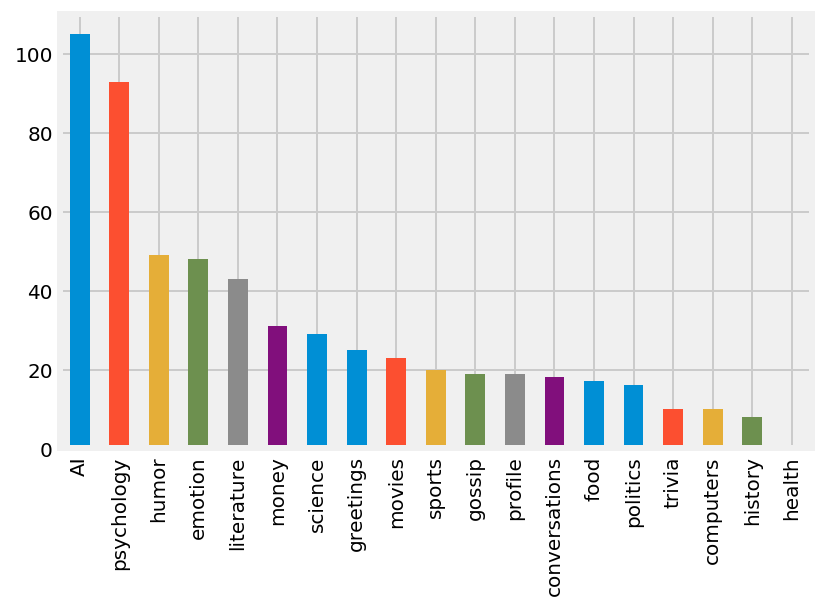

In [11]:
data["category"].value_counts().plot.bar()

In [12]:
data.to_csv("dataset_not_preprocessed.csv")

In [13]:
data.head()

,question,answer,category
0,['What is AI?','Artificial Intelligence is the branch of eng...,AI
1,['What is AI?','AI is the field of science which concerns it...,AI
2,['Are you sentient?','Sort of.'],AI
3,['Are you sentient?',"""By the strictest dictionary definition of th...",AI
4,['Are you sentient?',"""Even though I'm a construct I do have a subj...",AI


In [14]:
preprocessed_text = []
for sent in data["question"]:
    sentence=[]
    for word in sent.split():
        word=word.lower()
        word = ("".join(x for x in word if x.isalnum()))
        sentence.append(word)
    
    preprocessed_text.append(" ".join(str(x) for x in sentence))

In [15]:
data["question"] = preprocessed_text

In [16]:
preprocessed_text = []
for sent in data["answer"]:
    sentence=[]
    for word in sent.split():
        word=word.lower()
        word = ("".join(x for x in word if x.isalnum()))
        sentence.append(word)
    
    preprocessed_text.append(" ".join(str(x) for x in sentence))

In [17]:
data["answer"] = preprocessed_text

In [18]:
data.head()

,question,answer,category
0,what is ai,artificial intelligence is the branch of engin...,AI
1,what is ai,ai is the field of science which concerns itse...,AI
2,are you sentient,sort of,AI
3,are you sentient,by the strictest dictionary definition of the ...,AI
4,are you sentient,even though im a construct i do have a subject...,AI


In [19]:
data.to_csv("dataset_preprocessed.csv")

<B> Preparing word2vec using own text corpus</B>

In [ ]:
data=pd.read_csv("dataset_preprocessed.csv")

In [20]:
sent = data["question"][0]+" "+data["answer"][0]
sent

'what is ai artificial intelligence is the branch of engineering and science devoted to constructing machines that think'

In [21]:
list_of_sent=[]

for i in range(len(data["question"])):
    sent = data["question"][i]+" "+data["answer"][i]
    list_of_sent.append(sent.split())

In [22]:
len(list_of_sent)

584

In [23]:
import gensim
model_word2vec = gensim.models.Word2Vec(list_of_sent,min_count=5,size=300, workers=4)

<B> Preparing word2vec using own Google news data </B>

In [24]:
pretrained_embeddings_path = "GoogleNews-vectors-negative300.bin"

model_word2vec = gensim.models.KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)

In [25]:
question_vector=[]
for sent in data["question"]:
    sent_vec = [model_word2vec[w] for w in sent if w in model_word2vec.wv.vocab]
    question_vector.append(sent_vec)

In [26]:
answer_vector=[]
for sent in data["answer"]:
    sent_vec = [model_word2vec[w] for w in sent if w in model_word2vec.wv.vocab]
    answer_vector.append(sent_vec)

In [27]:
data["answer"][1]

'ai is the field of science which concerns itself with building hardware and software that replicates the functions of the human mind'

In [28]:
sentend=np.ones((300,),dtype=np.float32) 

In [29]:
for sent in question_vector:
    sent[19:]=[]
    sent.append(sentend)

In [30]:
for sent in question_vector:
    if(len(sent)<20):
        for i in range(20-len(sent)):
            sent.append(sentend)

In [31]:
for sent in answer_vector:
    sent[19:]=[]
    sent.append(sentend)

In [32]:
for sent in answer_vector:
    if(len(sent)<20):
        for i in range(20-len(sent)):
            sent.append(sentend)

In [33]:
import pickle
with open('conversation.pickle','wb') as f:
    pickle.dump([question_vector,answer_vector],f)

In [40]:
import os
import pickle
import numpy as np
from keras.models import Sequential
import gensim
from keras.layers.recurrent import LSTM,SimpleRNN
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization

In [ ]:
with open('conversation.pickle','rb') as f:
    question_vector , answer_vector = pickle.load(f)    

In [41]:
vec_x=np.array(question_vector,dtype=np.float64)
vec_y=np.array(answer_vector,dtype=np.float64)

In [42]:
vec_x.size

3504000

In [43]:
x_train,x_test, y_train,y_test = train_test_split(vec_x, vec_y, test_size=0.2, random_state=1)

In [44]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(467, 20, 300) (467, 20, 300) (117, 20, 300) (117, 20, 300)


In [45]:
model=Sequential()

model.add(LSTM(output_dim=300,input_shape=x_train.shape[1:],return_sequences=True, init='glorot_normal', inner_init='glorot_normal', activation='relu'))
model.add(Dropout(0.5))

model.add(LSTM(output_dim=300,input_shape=x_train.shape[1:],return_sequences=True, init='glorot_normal', inner_init='glorot_normal', activation='relu'))
model.add(Dropout(0.5))

model.add(LSTM(output_dim=300,input_shape=x_train.shape[1:],return_sequences=True, init='glorot_normal', inner_init='glorot_normal', activation='relu'))
model.add(Dropout(0.5))

model.add(LSTM(output_dim=300,input_shape=x_train.shape[1:],return_sequences=True, init='glorot_normal', inner_init='glorot_normal', activation='relu'))
model.add(Dropout(0.5))

model.compile(loss='cosine_proximity', optimizer='adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 20, 300)           721200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 300)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 300)           721200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 300)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 300)           721200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 20, 300)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 20, 300)           721200    
__________

In [46]:
model.fit(x_train, y_train, nb_epoch=200,validation_data=(x_test, y_test))

Train on 467 samples, validate on 117 samples
Epoch 1/200
467/467 [==============================] - 10s 21ms/step - loss: -0.3021 - acc: 0.0407 - val_loss: -0.4905 - val_acc: 0.0573
Epoch 2/200
467/467 [==============================] - 6s 13ms/step - loss: -0.3459 - acc: 0.0582 - val_loss: -0.4968 - val_acc: 0.0483
Epoch 3/200
467/467 [==============================] - 7s 14ms/step - loss: -0.3485 - acc: 0.0534 - val_loss: -0.4992 - val_acc: 0.0654
Epoch 4/200
467/467 [==============================] - 7s 14ms/step - loss: -0.3492 - acc: 0.0572 - val_loss: -0.4991 - val_acc: 0.0611
Epoch 5/200
467/467 [==============================] - 6s 13ms/step - loss: -0.3507 - acc: 0.0613 - val_loss: -0.5015 - val_acc: 0.0620
Epoch 6/200
467/467 [==============================] - 6s 14ms/step - loss: -0.3518 - acc: 0.0617 - val_loss: -0.5012 - val_acc: 0.0637
Epoch 7/200
467/467 [==============================] - 6s 14ms/step - loss: -0.3521 - acc: 0.0605 - val_loss: -0.5008 - val_acc: 0.0628
E

467/467 [==============================] - 7s 15ms/step - loss: -0.3741 - acc: 0.0621 - val_loss: -0.5079 - val_acc: 0.0688
Epoch 61/200
467/467 [==============================] - 7s 16ms/step - loss: -0.3760 - acc: 0.0745 - val_loss: -0.5068 - val_acc: 0.0714
Epoch 62/200
467/467 [==============================] - 7s 15ms/step - loss: -0.3761 - acc: 0.0686 - val_loss: -0.5101 - val_acc: 0.0688
Epoch 63/200
467/467 [==============================] - 7s 15ms/step - loss: -0.3773 - acc: 0.0635 - val_loss: -0.5073 - val_acc: 0.0769
Epoch 64/200
467/467 [==============================] - 7s 15ms/step - loss: -0.3774 - acc: 0.0645 - val_loss: -0.5137 - val_acc: 0.0692
Epoch 65/200
467/467 [==============================] - 7s 15ms/step - loss: -0.3767 - acc: 0.0690 - val_loss: -0.5098 - val_acc: 0.0714
Epoch 66/200
467/467 [==============================] - 8s 17ms/step - loss: -0.3762 - acc: 0.0623 - val_loss: -0.5128 - val_acc: 0.0667
Epoch 67/200
467/467 [==============================] 

Epoch 120/200
467/467 [==============================] - 8s 17ms/step - loss: -0.3900 - acc: 0.0746 - val_loss: -0.5094 - val_acc: 0.0808
Epoch 121/200
467/467 [==============================] - 7s 16ms/step - loss: -0.3900 - acc: 0.0744 - val_loss: -0.5055 - val_acc: 0.0885
Epoch 122/200
467/467 [==============================] - 7s 16ms/step - loss: -0.3912 - acc: 0.0723 - val_loss: -0.5088 - val_acc: 0.0855
Epoch 123/200
467/467 [==============================] - 7s 16ms/step - loss: -0.3911 - acc: 0.0770 - val_loss: -0.5123 - val_acc: 0.0855
Epoch 124/200
467/467 [==============================] - 7s 16ms/step - loss: -0.3910 - acc: 0.0741 - val_loss: -0.5105 - val_acc: 0.0791
Epoch 125/200
467/467 [==============================] - 7s 16ms/step - loss: -0.3918 - acc: 0.0772 - val_loss: -0.5114 - val_acc: 0.0876
Epoch 126/200
467/467 [==============================] - 7s 16ms/step - loss: -0.3919 - acc: 0.0798 - val_loss: -0.5063 - val_acc: 0.0863
Epoch 127/200
467/467 [===========

467/467 [==============================] - 8s 16ms/step - loss: -0.3958 - acc: 0.0846 - val_loss: -0.5130 - val_acc: 0.0855
Epoch 180/200
467/467 [==============================] - 8s 17ms/step - loss: -0.3965 - acc: 0.0850 - val_loss: -0.5099 - val_acc: 0.0940
Epoch 181/200
467/467 [==============================] - 7s 16ms/step - loss: -0.3971 - acc: 0.0849 - val_loss: -0.5096 - val_acc: 0.0885
Epoch 182/200
467/467 [==============================] - 7s 16ms/step - loss: -0.3966 - acc: 0.0834 - val_loss: -0.5080 - val_acc: 0.0829
Epoch 183/200
467/467 [==============================] - 7s 16ms/step - loss: -0.3963 - acc: 0.0850 - val_loss: -0.5096 - val_acc: 0.0842
Epoch 184/200
467/467 [==============================] - 7s 16ms/step - loss: -0.3971 - acc: 0.0840 - val_loss: -0.5125 - val_acc: 0.0872
Epoch 185/200
467/467 [==============================] - 7s 16ms/step - loss: -0.3969 - acc: 0.0850 - val_loss: -0.5138 - val_acc: 0.0932
Epoch 186/200
467/467 [=========================

In [47]:
model.save('LSTM_chatbot.h5')   